# Parte 1

### 1.1

In [2]:
from keras.datasets import mnist
import numpy as np
import keras
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
X_train  = np.expand_dims(X_train, axis=3)
X_test = np.expand_dims(X_test, axis=3)
img_rows, img_cols, channel = X_train.shape[1:]

Using TensorFlow backend.


In [38]:
# input image dimensions
original_img_size = (img_rows, img_cols, channel)
# number of convolutional filters to use
filters = 32
# convolution kernel size
num_conv = 3
latent_dim = 2
intermediate_dim = 128
from keras.layers import Input,Conv2D,Flatten,Dense,MaxPool2D
from keras.models import Model
## Encoder
x = Input(shape=original_img_size)
conv_1 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu')(x)
conv_2 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu')(conv_1)
conv_3 = Conv2D(filters*2, kernel_size=num_conv, padding='same', activation='relu', strides=2)(conv_2)
flat = Flatten()(conv_3)
hidden = Dense(intermediate_dim, activation='relu')(flat)
z_mean = Dense(latent_dim,activation='linear')(hidden)
z_log_var = Dense(latent_dim,activation='linear')(hidden)
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

a) La arquitectura del modelo del encoder comienza con un stack de tres convoluciones, las cuales terminan en una capa <i>fully conceted</i> la cual a la vez está conectada con una última capa de 2 variables latentes.

In [39]:
from keras import backend as K
from keras.layers import Reshape,Conv2DTranspose,Activation
## Decoder
shape_before_flattening = K.int_shape(conv_3)[1:]
# we instantiate these layers separately so as to reuse them later
decoder_hid = Dense(intermediate_dim, activation='relu')
decoder_upsample = Dense(np.prod(shape_before_flattening), activation='relu')
decoder_reshape = Reshape(shape_before_flattening)
decoder_deconv_1 = Conv2DTranspose(filters,kernel_size=num_conv, padding='same',strides=2,activation='relu')
decoder_deconv_2 = Conv2DTranspose(filters,kernel_size=num_conv,padding='same', activation='relu')
decoder_mean_squash = Conv2DTranspose(channel, kernel_size=num_conv,padding='same', activation='sigmoid')

b) El objetivo de una capa convolucional transpuesta es ir en la dirección contraria a una convolución normal. Es útil en el caso de el autoender variacional ya que se quiere reconstruir la imagen original a partir de las variables latentes obtenidas en el proceso de encode, la arquitectura del decoder es un espejo de la que se uso en el encoder pero en la dirección contraria con tal de reconstruir la imagen.

In [40]:
def sampling(args):
    epsilon_std = 1.0
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var) * epsilon
from keras.layers import Lambda
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded =  decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1(reshape_decoded)
x_decoded_relu = decoder_deconv_2(deconv_1_decoded)
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)
# instantiate VAE model
vae = Model(x, x_decoded_mean_squash)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 28, 28, 32)   320         input_22[0][0]                   
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 28, 28, 32)   9248        conv2d_4[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_5[0][0]                   
__________________________________________________________________________________________________
flatten_2 

C) El modelo completo actua como un espejo, que busca transformar el input que en este caso corresponde a las imagenes de números dibujados en 2 variables latentes para luego de estas 2 variables latentes reconstruir la imagen que tuvo como input el modelo. El modelo además busca que las variables latentes se distribuyan de forma normal.

In [41]:
# Compute VAE loss
#choised_loss =  keras.metrics.binary_crossentropy(K.flatten(x),K.flatten(x_decoded_mean_squash))
choised_loss =  keras.metrics.mean_squared_error(K.flatten(x),K.flatten(x_decoded_mean_squash))
reconstruction_loss = img_rows * img_cols * channel* choised_loss
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

d) Se escoge como función de perdida MSE, ya que los valores que se obtienen por la distribución que se busca van fuera del rango que permite <i>binary crossentropy</i>. KL divergence mide la divergencia que existe entre 2 probabilidades, es útil en el entrenamiento del VAE ya que minimizar la KL divergence significa que se está optimizando la probabilidad de la distribución de los parámetros $\mu$ y $\sigma$ para que se acerquen a los búscados, que corresponden a los de la distribución normal.

In [42]:
batch_size = 32
epochs =  10
vae.compile(optimizer='rmsprop')
vae.fit(X_train,epochs=epochs, batch_size=batch_size,validation_data=(X_test, None))

C:\Users\Daniel\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: UserWarning: Output "conv2d_transpose_6" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "conv2d_transpose_6" during training.
  app.launch_new_instance()


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 43s 725us/step - loss: 40.5866 - val_loss: 36.2960

e) Se entrena por una cantidad de 10 epochs obteniendose un valor para la función de perdida de 32.7049, se escoge un tamaño de batch de 32 porque parece un tamaño aceptable para obtener buenos resultados y a la vez un entrenamiento rápido. 

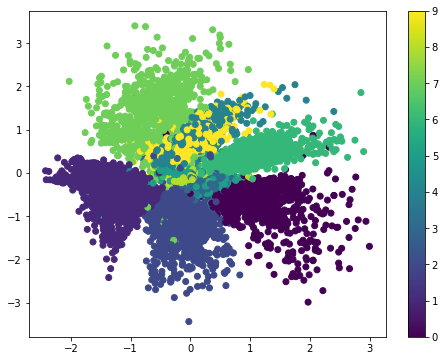

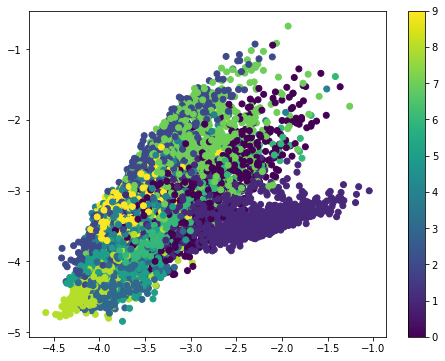

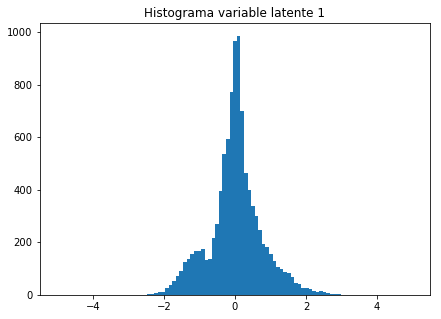

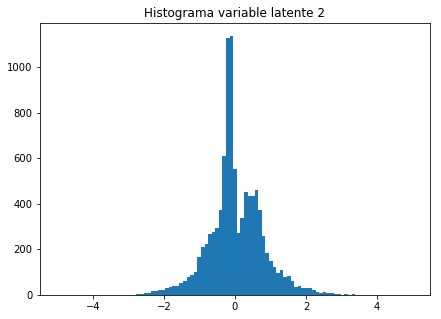

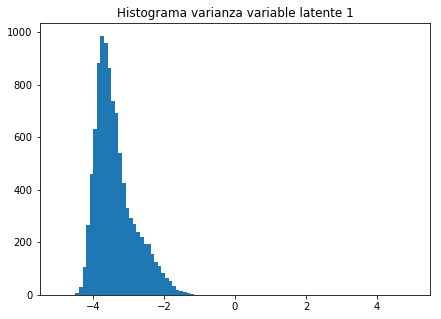

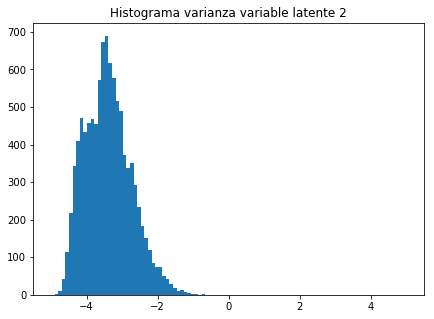

In [55]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(X_test, batch_size=batch_size)
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()
encoder_log_var = Model(x,z_log_var)
x_test_encoded_log_var = encoder_log_var.predict(X_test, batch_size=batch_size)
plt.figure(figsize=(8, 6))
plt.scatter(x_test_encoded_log_var[:, 0], x_test_encoded_log_var[:, 1], c=y_test)
plt.colorbar()
plt.show()
#histogram
bins = np.linspace(-5, 5, 100)
plt.figure(figsize=(7, 5))
plt.hist(x_test_encoded[:, 0], bins)
plt.title("Histograma variable latente 1")
plt.show()
plt.figure(figsize=(7, 5))
plt.hist(x_test_encoded[:, 1], bins)
plt.title("Histograma variable latente 2")
plt.show()
plt.figure(figsize=(7, 5))
plt.hist(x_test_encoded_log_var[:, 0], bins)
plt.title("Histograma varianza variable latente 1")
plt.show()
plt.figure(figsize=(7, 5))
plt.hist(x_test_encoded_log_var[:, 1], bins)
plt.title("Histograma varianza variable latente 2")
plt.show()

f) Se puede ver en el gráfico de dispersión como el modelo logra separar de buena manera alguna de la clsases, mientras que para otras se hace más complicado. Por otro lado en los histogramas se puede ver como para las variables latentes se obtiene que en general se comportan del modo esperado, es decir, se distribuyen de forma normal.

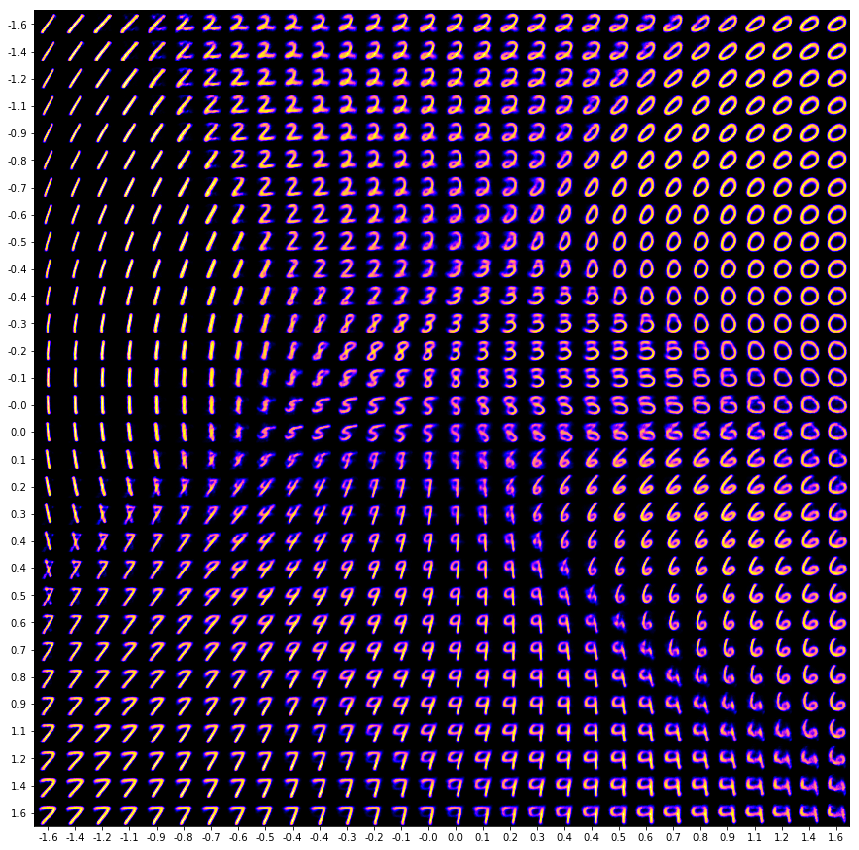

In [67]:
#GENERATOR
decoder_input = Input(shape=(latent_dim,))
_hid_decoded = decoder_hid(decoder_input)
_up_decoded = decoder_upsample(_hid_decoded)
_reshape_decoded = decoder_reshape(_up_decoded)
_deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
_x_decoded_relu = decoder_deconv_2(_deconv_1_decoded)
_x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
generator = Model(decoder_input, _x_decoded_mean_squash)
##PLOT
n = 30  # figure with 15x15 images 
image_size = img_cols
figure = np.zeros((image_size * n, image_size * n))
from scipy.stats import norm
#metodo de la transformada inversa
grid_x = norm.ppf(np.linspace(0.05, 0.95, n), loc=0, scale=1)
grid_y = norm.ppf(np.linspace(0.05, 0.95, n), loc=0, scale=1)
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])            
        x_decoded = generator.predict(z_sample,batch_size=batch_size)
        figure[i * image_size: (i + 1) * image_size,
               j * image_size: (j + 1) * image_size] = x_decoded[0][:,:,0]
plt.figure(figsize=(15, 15))
plt.imshow(figure,cmap='gnuplot2')
pos = np.arange(image_size/2,image_size*n,image_size)
plt.yticks(pos,np.round(grid_y,1))
plt.xticks(pos,np.round(grid_x,1))
plt.show()
#en los extremos del intervalo de confianza
grid = norm.ppf(np.linspace(0.000005, 0.999995, n))

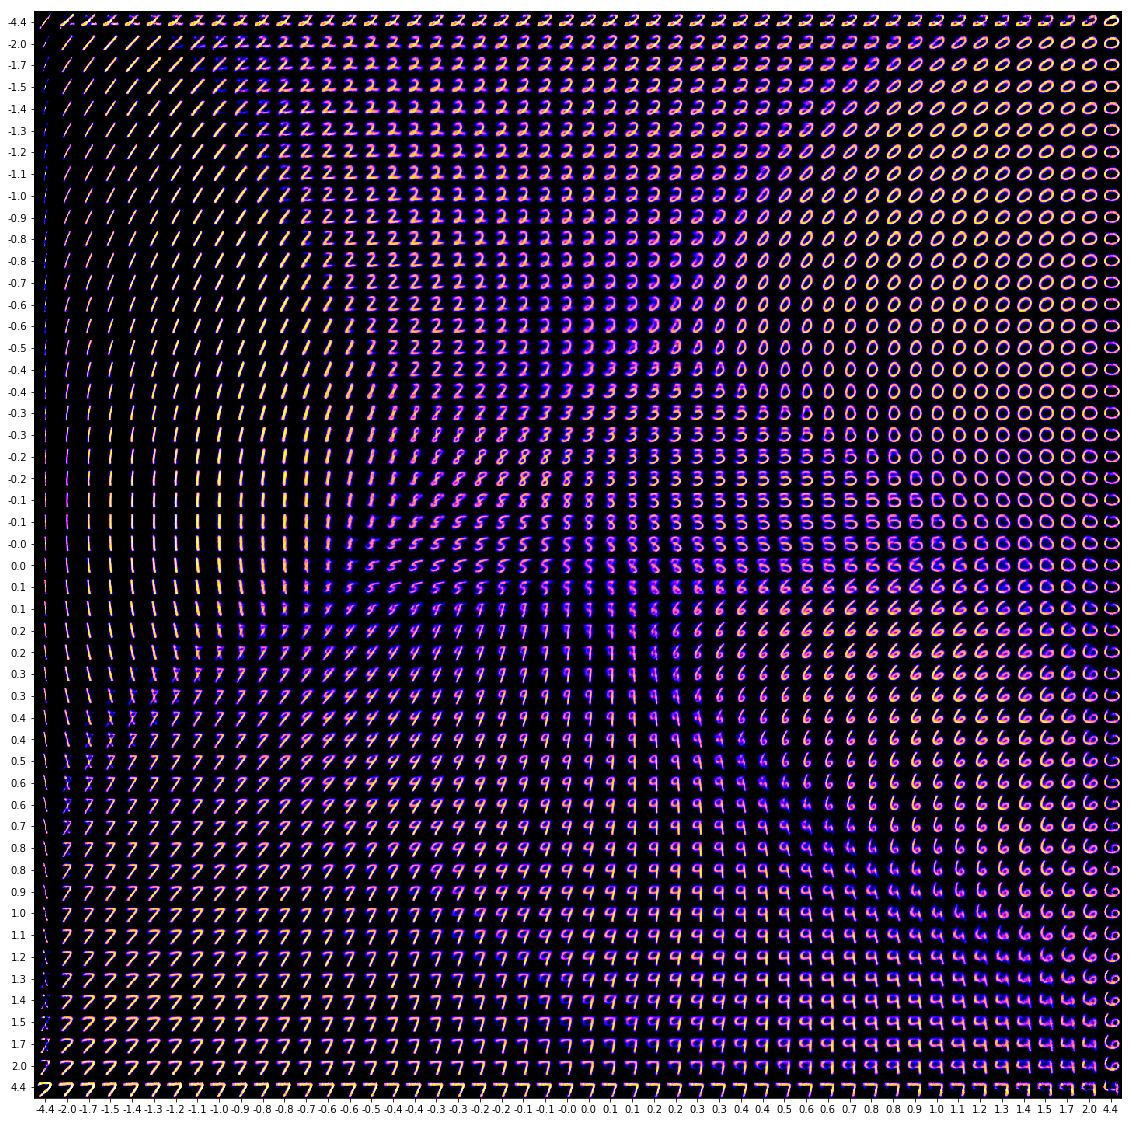

In [76]:
##PLOT
n = 50  # figure with 15x15 images 
image_size = img_cols
figure = np.zeros((image_size * n, image_size * n))
from scipy.stats import norm
#metodo de la transformada inversa
grid_x = norm.ppf(np.linspace(0.000005, 0.999995, n), loc=0, scale=1)
grid_y = norm.ppf(np.linspace(0.000005, 0.999995, n), loc=0, scale=1)
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])            
        x_decoded = generator.predict(z_sample,batch_size=batch_size)
        figure[i * image_size: (i + 1) * image_size,
               j * image_size: (j + 1) * image_size] = x_decoded[0][:,:,0]
plt.figure(figsize=(20, 20))
plt.imshow(figure,cmap='gnuplot2')
pos = np.arange(image_size/2,image_size*n,image_size)
plt.yticks(pos,np.round(grid_y,1))
plt.xticks(pos,np.round(grid_x,1))
plt.show()
#en los extremos del intervalo de confianza
grid = norm.ppf(np.linspace(0.000005, 0.999995, n))

g) En la imagen generada cada eje correspnode al valor de una de las variables latenetes. Las imagenes que se generan son las respuestas del decoder para un input de 2 variables correspondientes a las 2 variables latentes. Más allá del espacio del 90% se puede ver que en las orillas de la imagen generada las respuestas entregadas no son tan nítidas como para decir con certeza de que número se trata, también si se centra la atención en torno al punto (0,0) o torno al (1,1) se puede ver que tampoco se puede discernir con claridad de que número se trata, esto coincide con lo observado en el gráfico de dispersión en el punto que se señalo que no se diferenciaban de buena forma una clase de otra.

h)

In [12]:
# input image dimensions
original_img_size = (img_rows, img_cols, channel)
# number of convolutional filters to use
filters = 32
# convolution kernel size
num_conv = 3
latent_dim = 3
intermediate_dim = 128
from keras.layers import Input,Conv2D,Flatten,Dense,MaxPool2D
from keras.models import Model
## Encoder
x = Input(shape=original_img_size)
conv_1 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu')(x)
conv_2 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu')(conv_1)
conv_3 = Conv2D(filters*2, kernel_size=num_conv, padding='same', activation='relu', strides=2)(conv_2)
flat = Flatten()(conv_3)
hidden = Dense(intermediate_dim, activation='relu')(flat)
z_mean = Dense(latent_dim,activation='linear')(hidden)
z_log_var = Dense(latent_dim,activation='linear')(hidden)
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

from keras import backend as K
from keras.layers import Reshape,Conv2DTranspose,Activation
## Decoder
shape_before_flattening = K.int_shape(conv_3)[1:]
# we instantiate these layers separately so as to reuse them later
decoder_hid = Dense(intermediate_dim, activation='relu')
decoder_upsample = Dense(np.prod(shape_before_flattening), activation='relu')
decoder_reshape = Reshape(shape_before_flattening)
decoder_deconv_1 = Conv2DTranspose(filters,kernel_size=num_conv, padding='same',strides=2,activation='relu')
decoder_deconv_2 = Conv2DTranspose(filters,kernel_size=num_conv,padding='same', activation='relu')
decoder_mean_squash = Conv2DTranspose(channel, kernel_size=num_conv,padding='same', activation='sigmoid')

def sampling(args):
    epsilon_std = 1.0
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var) * epsilon
from keras.layers import Lambda
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded =  decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1(reshape_decoded)
x_decoded_relu = decoder_deconv_2(deconv_1_decoded)
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)
# instantiate VAE model
vae = Model(x, x_decoded_mean_squash)

# Compute VAE loss
#choised_loss =  keras.metrics.binary_crossentropy(K.flatten(x),K.flatten(x_decoded_mean_squash))
choised_loss =  keras.metrics.mean_squared_error(K.flatten(x),K.flatten(x_decoded_mean_squash))
reconstruction_loss = img_rows * img_cols * channel* choised_loss
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

batch_size = 32
epochs =  10
vae.compile(optimizer='rmsprop')
vae.fit(X_train,epochs=epochs, batch_size=batch_size,validation_data=(X_test, None))

C:\Users\Daniel\Anaconda3\lib\site-packages\ipykernel\__main__.py:61: UserWarning: Output "conv2d_transpose_6" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "conv2d_transpose_6" during training.


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 45s 753us/step - loss: 37.0533 - val_loss: 32.6377

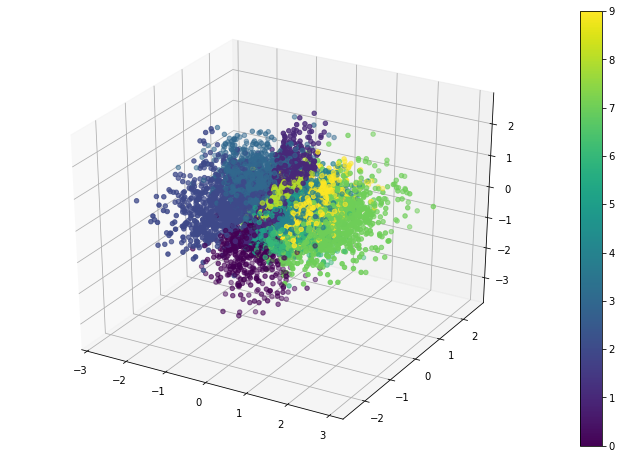

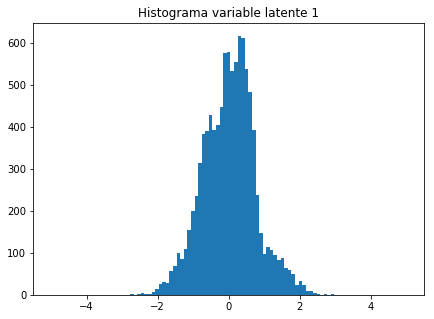

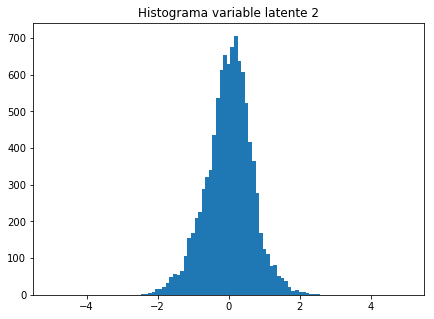

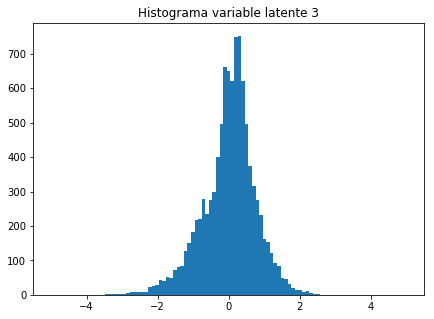

In [41]:
x_test_encoded = encoder.predict(X_test, batch_size=batch_size)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
axx = ax.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], x_test_encoded[:, 2], c=y_test)
plt.colorbar(axx)
plt.show()
bins = np.linspace(-5, 5, 100)
plt.figure(figsize=(7, 5))
plt.hist(x_test_encoded[:, 0], bins)
plt.title("Histograma variable latente 1")
plt.show()
plt.figure(figsize=(7, 5))
plt.hist(x_test_encoded[:, 1], bins)
plt.title("Histograma variable latente 2")
plt.show()
plt.figure(figsize=(7, 5))
plt.hist(x_test_encoded[:, 2], bins)
plt.title("Histograma variable latente 3")
plt.show()

In [86]:
# input image dimensions
original_img_size = (img_rows, img_cols, channel)
# number of convolutional filters to use
filters = 32
# convolution kernel size
num_conv = 3
latent_dim = 5
intermediate_dim = 128
from keras.layers import Input,Conv2D,Flatten,Dense,MaxPool2D
from keras.models import Model
## Encoder
x = Input(shape=original_img_size)
conv_1 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu')(x)
conv_2 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu')(conv_1)
conv_3 = Conv2D(filters*2, kernel_size=num_conv, padding='same', activation='relu', strides=2)(conv_2)
flat = Flatten()(conv_3)
hidden = Dense(intermediate_dim, activation='relu')(flat)
z_mean = Dense(latent_dim,activation='linear')(hidden)
z_log_var = Dense(latent_dim,activation='linear')(hidden)
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

from keras import backend as K
from keras.layers import Reshape,Conv2DTranspose,Activation
## Decoder
shape_before_flattening = K.int_shape(conv_3)[1:]
# we instantiate these layers separately so as to reuse them later
decoder_hid = Dense(intermediate_dim, activation='relu')
decoder_upsample = Dense(np.prod(shape_before_flattening), activation='relu')
decoder_reshape = Reshape(shape_before_flattening)
decoder_deconv_1 = Conv2DTranspose(filters,kernel_size=num_conv, padding='same',strides=2,activation='relu')
decoder_deconv_2 = Conv2DTranspose(filters,kernel_size=num_conv,padding='same', activation='relu')
decoder_mean_squash = Conv2DTranspose(channel, kernel_size=num_conv,padding='same', activation='sigmoid')

def sampling(args):
    epsilon_std = 1.0
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var) * epsilon
from keras.layers import Lambda
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded =  decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1(reshape_decoded)
x_decoded_relu = decoder_deconv_2(deconv_1_decoded)
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)
# instantiate VAE model
vae = Model(x, x_decoded_mean_squash)

# Compute VAE loss
#choised_loss =  keras.metrics.binary_crossentropy(K.flatten(x),K.flatten(x_decoded_mean_squash))
choised_loss =  keras.metrics.mean_squared_error(K.flatten(x),K.flatten(x_decoded_mean_squash))
reconstruction_loss = img_rows * img_cols * channel* choised_loss
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

batch_size = 32
epochs =  10
vae.compile(optimizer='rmsprop')
vae.fit(X_train,epochs=epochs, batch_size=batch_size,validation_data=(X_test, None))

C:\Users\Daniel\Anaconda3\lib\site-packages\ipykernel\__main__.py:61: UserWarning: Output "conv2d_transpose_15" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "conv2d_transpose_15" during training.


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 44s 730us/step - loss: 32.1702 - val_loss: 27.4905

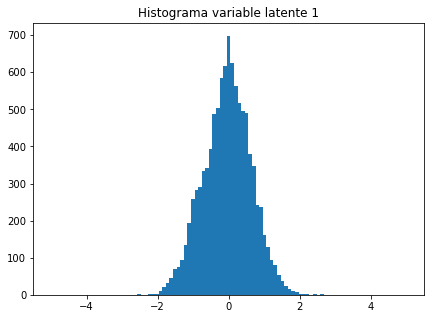

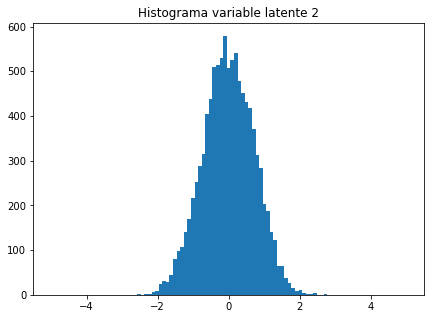

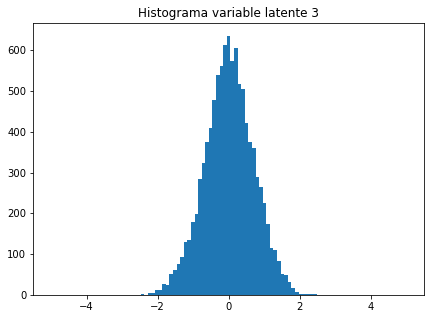

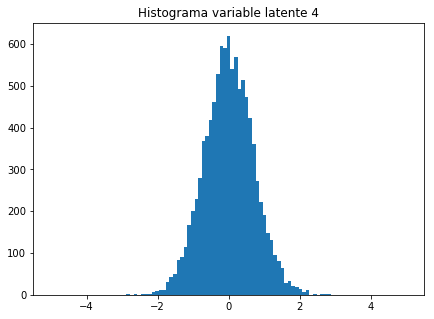

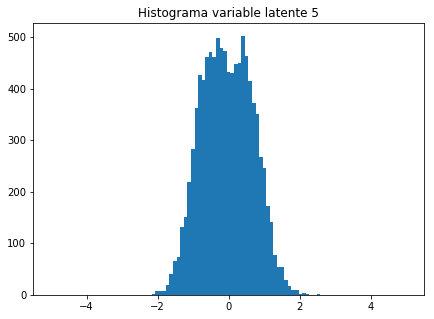

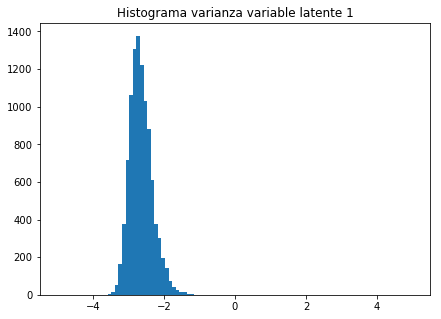

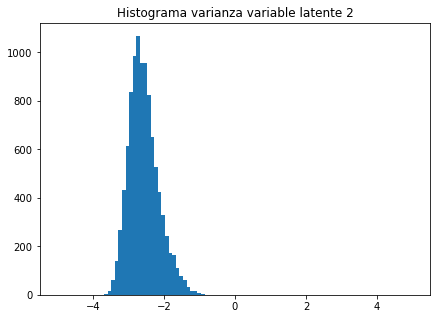

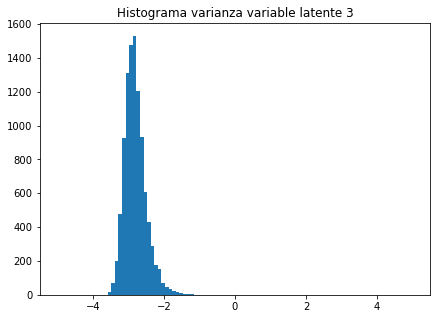

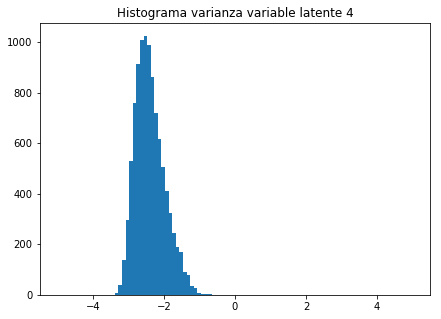

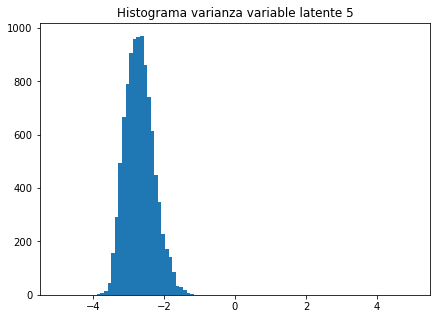

In [90]:
#histogramas para 5 variables latentes

i) Se prueba con 3 y 5 variables latentes, obteniendo una mejora por sobre cuando se trabaja con solo 2. Se obtienen así los siguientes resultados para la función de perdida con el set de test: 
<br> 2 variables: 32.59 <br> 3 variables: 28.61 <br> 5 variables: 23.53 
<br>
Cabe señalar que para estos nuevos casos se puede observar como la distribución de las variables latentes se acerca más a una normal que para el caso cuando solo se considera 2 variables.
<br> El resultado obtenido tiene sentido y es esperado ya que, al poseer un mayor número de variables tiene más posibilidades de dispersar en el espacio lo aprendido, así como posee más parámetros para guardar información relevante.

In [49]:
# input image dimensions
original_img_size = (img_rows, img_cols, channel)
# number of convolutional filters to use
filters = 32
# convolution kernel size
num_conv = 3
latent_dim = 2
intermediate_dim = 128
from keras.layers import Input,Conv2D,Flatten,Dense,MaxPool2D
from keras.models import Model
## Encoder
x = Input(shape=original_img_size)
conv_1 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu')(x)
conv_2 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu')(conv_1)
conv_3 = Conv2D(filters*2, kernel_size=num_conv, padding='same', activation='relu', strides=2)(conv_2)
conv_4 = Conv2D(filters*2, kernel_size=num_conv, padding='same', activation='relu', strides=2)(conv_3)
flat = Flatten()(conv_4)
hidden = Dense(intermediate_dim, activation='relu')(flat)
z_mean = Dense(latent_dim,activation='linear')(hidden)
z_log_var = Dense(latent_dim,activation='linear')(hidden)
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

from keras import backend as K
from keras.layers import Reshape,Conv2DTranspose,Activation
## Decoder
shape_before_flattening = K.int_shape(conv_4)[1:]
# we instantiate these layers separately so as to reuse them later
decoder_hid = Dense(intermediate_dim, activation='relu')
decoder_upsample = Dense(np.prod(shape_before_flattening), activation='relu')
decoder_reshape = Reshape(shape_before_flattening)
decoder_deconv_0 = Conv2DTranspose(filters,kernel_size=num_conv, padding='same',strides=2,activation='relu')
decoder_deconv_1 = Conv2DTranspose(filters,kernel_size=num_conv, padding='same',strides=2,activation='relu')
decoder_deconv_2 = Conv2DTranspose(filters,kernel_size=num_conv,padding='same', activation='relu')
decoder_mean_squash = Conv2DTranspose(channel, kernel_size=num_conv,padding='same', activation='sigmoid')

def sampling(args):
    epsilon_std = 1.0
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var) * epsilon
from keras.layers import Lambda
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded =  decoder_reshape(up_decoded)
deconv_0_decoded = decoder_deconv_0(reshape_decoded)
deconv_1_decoded = decoder_deconv_1(deconv_0_decoded)
x_decoded_relu = decoder_deconv_2(deconv_1_decoded)
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)
# instantiate VAE model
vae = Model(x, x_decoded_mean_squash)
vae.summary()

# Compute VAE loss
#choised_loss =  keras.metrics.binary_crossentropy(K.flatten(x),K.flatten(x_decoded_mean_squash))
choised_loss =  keras.metrics.mean_squared_error(K.flatten(x),K.flatten(x_decoded_mean_squash))
reconstruction_loss = img_rows * img_cols * channel* choised_loss
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

batch_size = 32
epochs =  10
vae.compile(optimizer='rmsprop')
vae.fit(X_train,epochs=epochs, batch_size=batch_size,validation_data=(X_test, None))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_35 (Conv2D)              (None, 28, 28, 32)   320         input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 28, 28, 32)   9248        conv2d_35[0][0]                  
__________________________________________________________________________________________________
conv2d_37 (Conv2D)              (None, 14, 14, 64)   18496       conv2d_36[0][0]                  
__________________________________________________________________________________________________
conv2d_38 

C:\Users\Daniel\Anaconda3\lib\site-packages\ipykernel\__main__.py:65: UserWarning: Output "conv2d_transpose_38" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "conv2d_transpose_38" during training.


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 70s 1ms/step - loss: 42.0980 - val_loss: 37.2881

j) En esta sección se entrena la misma red de 2 variables latentes con la que se trabajó en un principio pero a diferencia se le agrega una capa convolucional extra, la forma en que esta es agregada deja al modelo con solo un tercio de los parámetros entrenables que tenía la primera red, con esto se obtiene como resultado para la misma cantidad de epochs de entrenamiento un valor para la función de perdida un poco peor pero que no difiere en forma sustancial a la ya expuesta anteriormente, aunque hay que mencionar que la red es más liviana por su menor cantidad de parámetros.

### 1.2

In [4]:
from keras.models import Model,Sequential
from keras.layers import LeakyReLU,Conv2D,Dropout,Flatten,Dense
## Discriminator
D = Sequential()
depth = 64
dropout = 0.4
input_shape = (img_rows, img_cols, channel)
D.add(Conv2D(depth*1, (5,5), strides=2, input_shape=input_shape,padding='same', activation=LeakyReLU(alpha=0.2)))
D.add(Dropout(dropout))
D.add(Conv2D(depth*2, (5,5), strides=2, padding='same',activation=LeakyReLU(alpha=0.2)))
D.add(Dropout(dropout))
D.add(Conv2D(depth*4, (5,5), strides=2, padding='same',activation=LeakyReLU(alpha=0.2)))
D.add(Dropout(dropout))
D.add(Flatten())
D.add(Dense(1024,activation=LeakyReLU(alpha=0.2)))
D.add(Dense(1,activation='sigmoid'))
D.summary()

C:\Users\Daniel\Anaconda3\lib\site-packages\keras\activations.py:115: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         819456    
_________________________________________________________________
dropout_3 (Dropout)          (None, 4, 4, 256)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
__________

a) Como se está trabajando con imagenes, el modelo discriminador está compuesto por una serie bloques convolucionales que terminana en una tanda <i>fully connected</i> y como capa de salida una única neurona con activación sigmoidal. Es conveniente usar una activación sigmoidal como output ya que se busca discriminar si la imagen que recibió fue generada artificialmente o es real, y la función sigmoide tiene una imagen que va de [0,1], entonces con una única neurona de salida basta para clasificar una de estas dos situaciones.

In [5]:
from keras.layers import BatchNormalization,Reshape,UpSampling2D,Conv2DTranspose,Activation
## Generator
G = Sequential()
dim = 14
input_dim= 2 #para que sea similar al vAE
G.add(Dense(128, input_dim=input_dim))
G.add(BatchNormalization())
G.add(Activation('relu'))
G.add(Dense(dim*dim*depth))
G.add(BatchNormalization())
G.add(Activation('relu'))
G.add(Reshape((dim, dim, depth)))
G.add(Conv2DTranspose(int(depth/2), (3,3), padding='same',strides=(2,2)))
G.add(BatchNormalization())
G.add(Activation('relu'))
G.add(Conv2DTranspose(int(depth/2), (3,3), padding='same'))
G.add(BatchNormalization())
G.add(Activation('relu'))
G.add(Conv2DTranspose(channel, (3,3), padding='same')) 
G.add(Activation('sigmoid')) 
G.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               384       
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 12544)             1618176   
_________________________________________________________________
batch_normalization_2 (Batch (None, 12544)             50176     
_________________________________________________________________
activation_2 (Activation)    (None, 12544)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 14, 14, 64)        0         
__________

b) El modelo del generador se compone de un input de dos dimensiones, el cual es pasado por una tanda de capaz ocultas <i>fully connected</i> con batch normalization para mejorar el aprendizaje, para luego pasar por una tanda de deconvoluciones las cuales tienen como objeto construir una imagen de 28x28x1 que se corresponde con las imagenes del dataset MNIST. La función de activación del output se escoge como sigmoid dado la naturaleza del dataset y es que las imagenes están representadas como pixeles encendidos y apagados. 

In [6]:
from keras.optimizers import RMSprop
## Discriminator model (police)
optimizer = RMSprop(lr=0.0008, clipvalue=1.0, decay=6e-8)
DM = Sequential()
DM.add(D)
DM.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])
## Adversarial model (Generator->Discriminator)
D.trainable=False #set the discriminator freeze  (fixed params)
optimizer = RMSprop(lr=0.0004, clipvalue=1.0, decay=3e-8)
AM = Sequential()
AM.add(G)
AM.add(D)
AM.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])

c)

In [7]:
def train_on_steps(X_train,DM,AM,G,steps,batch_size):
    history = {"d":[],"g":[]}
    for e in range(train_steps):
        # Make generative images
        image_batch = X_train[np.random.randint(0,X_train.shape[0],size=batch_size),:,:,:] #sample images from real data
        noise_gen = np.random.uniform(-1,1,size=[batch_size,input_dim]) #sample image from generated data
        generated_images = G.predict(noise_gen) #fake images
        # Train discriminator on generated images
        X = np.concatenate((image_batch, generated_images))
        #create labels
        y = np.ones([2*batch_size,1])
        y[batch_size:,:] = 0
        d_loss  = DM.train_on_batch(X,y)
        history["d"].append(d_loss)
        # train Generator-Discriminator stack on input noise to non-generated output class
        noise_tr = np.random.uniform(-1,1,size=[batch_size,input_dim])
        y = np.ones([batch_size, 1])
        g_loss = AM.train_on_batch(noise_tr, y)
        history["g"].append(g_loss)
        if(e%(500)==0):
            log_mesg = "%d: [D loss: %f, acc: %f]" % (e, d_loss[0], d_loss[1])
            log_mesg = "%s  [G loss: %f, acc: %f]" % (log_mesg, g_loss[0], g_loss[1])
            print(log_mesg)
    print(log_mesg)        
    return history
train_steps = 5000 #or few if  you want
hist = train_on_steps(X_train,DM,AM,G,train_steps,64)

C:\Users\Daniel\Anaconda3\lib\site-packages\keras\engine\training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0: [D loss: 0.698810, acc: 0.429688]  [G loss: 4.434489, acc: 0.000000]
500: [D loss: 0.577226, acc: 0.710938]  [G loss: 0.552115, acc: 0.781250]
1000: [D loss: 0.614056, acc: 0.695312]  [G loss: 2.528667, acc: 0.000000]
1500: [D loss: 0.418965, acc: 0.773438]  [G loss: 1.404958, acc: 0.125000]
2000: [D loss: 0.462529, acc: 0.773438]  [G loss: 0.800856, acc: 0.484375]
2500: [D loss: 0.396726, acc: 0.789062]  [G loss: 1.164389, acc: 0.250000]
3000: [D loss: 0.334473, acc: 0.851562]  [G loss: 0.544905, acc: 0.656250]
3500: [D loss: 0.374325, acc: 0.851562]  [G loss: 0.330084, acc: 0.859375]
4000: [D loss: 0.052295, acc: 0.992188]  [G loss: 0.020460, acc: 1.000000]
4500: [D loss: 0.443693, acc: 0.851562]  [G loss: 2.130647, acc: 0.375000]
4500: [D loss: 0.443693, acc: 0.851562]  [G loss: 2.130647, acc: 0.375000]


In [8]:
d_loss = list()
g_loss = list()
d_acc = list()
g_acc = list()
for i in range(5000):
    d_loss.append(hist["d"][i][0])
    d_acc.append(hist["d"][i][1])
    g_loss.append(hist["g"][i][0])
    g_acc.append(hist["g"][i][1])

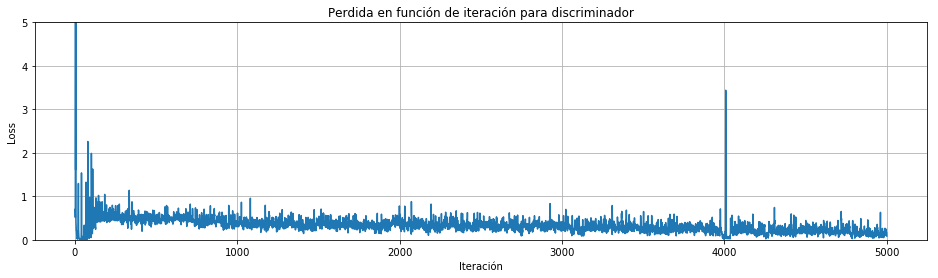

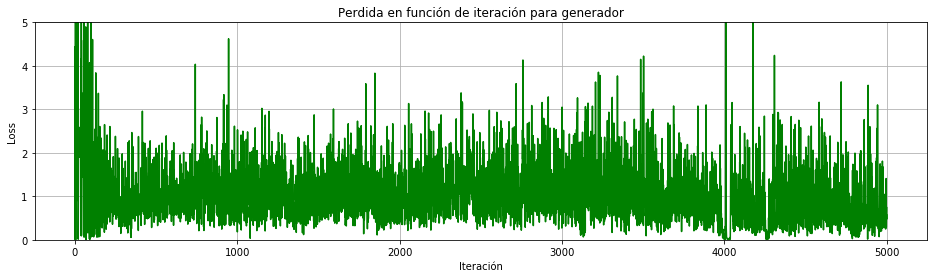

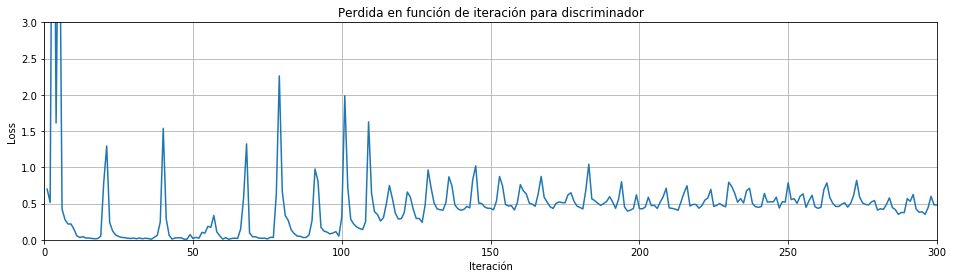

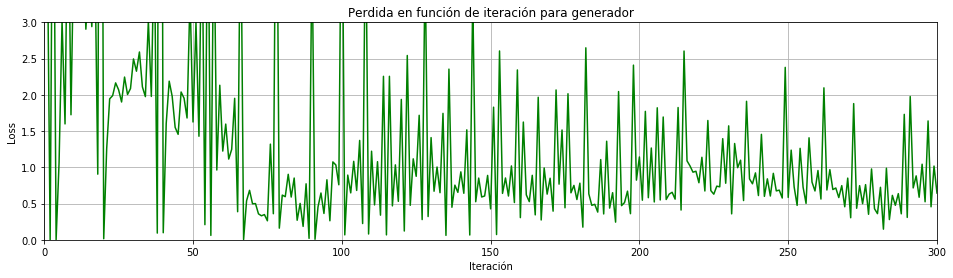

In [10]:
import matplotlib.pyplot as plt
rango = list(range(1,5001))
plt.figure(figsize=(16,4))
plt.ylim(0,5)
plt.ylabel("Loss")
plt.xlabel("Iteración")
plt.grid()
plt.title("Perdida en función de iteración para discriminador")
plt.plot(rango, d_loss)
plt.show()
plt.figure(figsize=(16,4))
plt.ylim(0,5)
plt.ylabel("Loss")
plt.xlabel("Iteración")
plt.grid()
plt.title("Perdida en función de iteración para generador")
plt.plot(rango, g_loss, color="g")
plt.show()

plt.figure(figsize=(16,4))
plt.ylim(0,3)
plt.xlim(0,300)
plt.ylabel("Loss")
plt.xlabel("Iteración")
plt.grid()
plt.title("Perdida en función de iteración para discriminador")
plt.plot(rango, d_loss)
plt.show()
plt.figure(figsize=(16,4))
plt.ylim(0,3)
plt.xlim(0,300)
plt.ylabel("Loss")
plt.xlabel("Iteración")
plt.grid()
plt.title("Perdida en función de iteración para generador")
plt.plot(rango, g_loss, color="g")
plt.show()

d) Conforme se avanza en el número de iteraciones y como se muestra en los gráficos las curvas para la perdida y accuracy presentan sobresaltos, esto es de esperarse y se debe al trade off que se hace entre el generador y el discriminadors. Y es que mientras se entrena uno se debe sacrificar del otro.

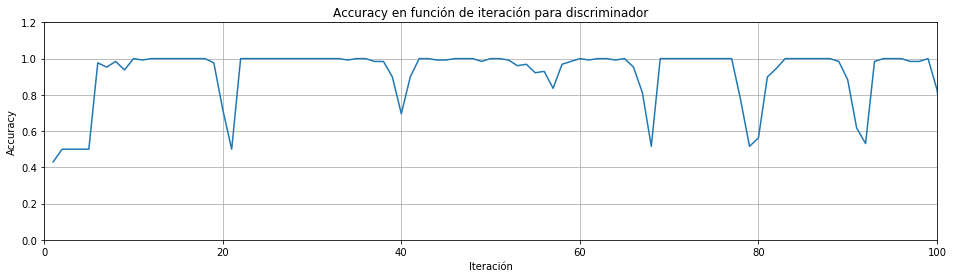

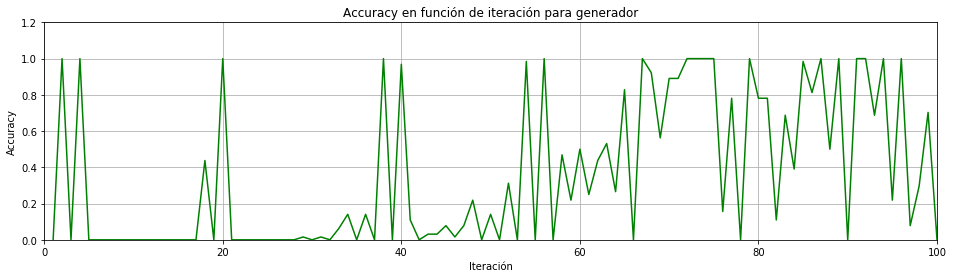

In [12]:
plt.figure(figsize=(16,4))
plt.ylim(0,1.2)
plt.xlim(0,100)
plt.ylabel("Accuracy")
plt.xlabel("Iteración")
plt.grid()
plt.title("Accuracy en función de iteración para discriminador")
plt.plot(rango, d_acc)
plt.show()
plt.figure(figsize=(16,4))
plt.ylim(0,1.2)
plt.xlim(0,100)
plt.ylabel("Accuracy")
plt.xlabel("Iteración")
plt.grid()
plt.title("Accuracy en función de iteración para generador")
plt.plot(rango, g_acc, color="g")
plt.show()


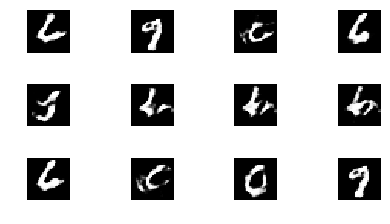

In [20]:
N = 12
noise = np.random.uniform(-1.0, 1.0, size=[N, input_dim]) 
images = G.predict(noise)
import matplotlib.pyplot as plt
for i in range(images.shape[0]):
    plt.subplot(4, 4, i+1)
    image = images[i, :, :, :]
    image = np.reshape(image, [img_rows, img_cols])
    plt.imshow(image, cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

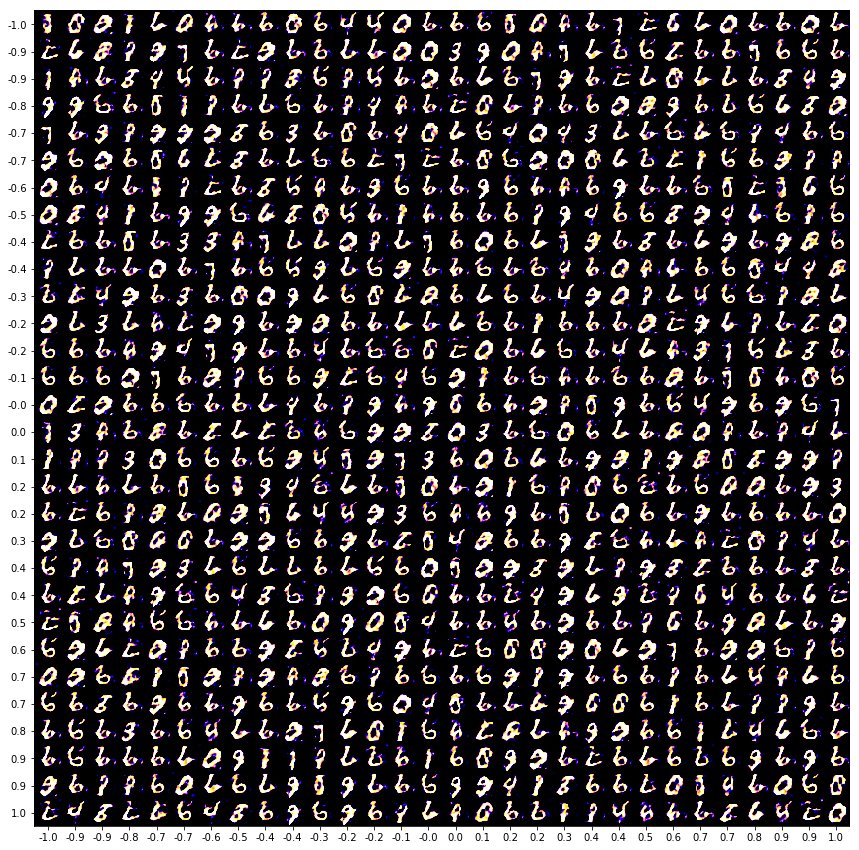

In [24]:
##PLOT
n = 30  # figure with 15x15 images 
image_size = img_cols
figure = np.zeros((image_size * n, image_size * n))
from scipy.stats import uniform
#metodo de la transformada inversa
grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        noise = np.random.uniform(-1.0, 1.0, size=[N, input_dim])            
        x_decoded = G.predict(noise)
        figure[i * image_size: (i + 1) * image_size,
               j * image_size: (j + 1) * image_size] = x_decoded[0][:,:,0]
plt.figure(figsize=(15, 15))
plt.imshow(figure,cmap='gnuplot2')
pos = np.arange(image_size/2,image_size*n,image_size)
plt.yticks(pos,np.round(grid_y,1))
plt.xticks(pos,np.round(grid_x,1))
plt.show()
#en los extremos del intervalo de confianza
grid = norm.ppf(np.linspace(0.000005, 0.999995, n))

e) Se prueba varias veces a generar imagenes artificiales con los datos de entrada artificiales y se puede destacar que predominan 2 números por sobre los demás y que son el 6 y 0, a pesar de que el dataset de entrenamiento es a partes iguales para cada clase. Esto se debe al espacio acotado que se dio para el input entre (-1,1). Destacable es el hecho que a diferencia de VAE el espacio no está distribuido por sectores si no que más bien las distintas clases se encuentran combinadas y distribuidas de igual forma en el espacio debido a la distribución escogida.

f) En un GAN ambos modelos son importantes y se requiere un equilibrio. Si se tuviera que escoger uno sobre otro sería el discriminador el escogido, ya que el objetivo final es tener un buen generador y si el discriminador es flojo entonces el generador podría pasar todas las imagenes como reales creyendo que hace un buen trabajo, siendo que podría ser el discriminador quien hace un mal trabajo.

In [29]:
def train_on_steps(X_train,DM,AM,G,steps,batch_size):
    history = {"d":[],"g":[]}
    for e in range(train_steps):
        # Make generative images
        image_batch = X_train[np.random.randint(0,X_train.shape[0],size=batch_size),:,:,:] #sample images from real data
        noise_gen = np.random.normal(size=[batch_size,input_dim]) #sample image from generated data
        generated_images = G.predict(noise_gen) #fake images
        # Train discriminator on generated images
        X = np.concatenate((image_batch, generated_images))
        #create labels
        y = np.ones([2*batch_size,1])
        y[batch_size:,:] = 0
        d_loss  = DM.train_on_batch(X,y)
        history["d"].append(d_loss)
        # train Generator-Discriminator stack on input noise to non-generated output class
        noise_tr = np.random.normal(size=[batch_size,input_dim])
        y = np.ones([batch_size, 1])
        g_loss = AM.train_on_batch(noise_tr, y)
        history["g"].append(g_loss)
        log_mesg = "%d: [D loss: %f, acc: %f]" % (e, d_loss[0], d_loss[1])
        log_mesg = "%s  [G loss: %f, acc: %f]" % (log_mesg, g_loss[0], g_loss[1])
        if(e%(500)==0):
            print(log_mesg)
    print(log_mesg)        
    return history
train_steps = 5000 #or few if  you want
hist = train_on_steps(X_train,DM,AM,G,train_steps,64)

C:\Users\Daniel\Anaconda3\lib\site-packages\keras\engine\training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0: [D loss: 0.194277, acc: 0.945312]  [G loss: 0.658925, acc: 0.750000]
500: [D loss: 0.137218, acc: 0.945312]  [G loss: 0.296744, acc: 0.843750]
1000: [D loss: 0.177239, acc: 0.906250]  [G loss: 0.228756, acc: 0.875000]
1500: [D loss: 0.095172, acc: 0.960938]  [G loss: 0.360015, acc: 0.812500]
2000: [D loss: 0.207745, acc: 0.937500]  [G loss: 0.596365, acc: 0.750000]
2500: [D loss: 0.111703, acc: 0.945312]  [G loss: 0.121773, acc: 0.953125]
3000: [D loss: 0.327725, acc: 0.898438]  [G loss: 1.628553, acc: 0.546875]
3500: [D loss: 0.099166, acc: 0.953125]  [G loss: 0.081830, acc: 0.968750]
4000: [D loss: 0.011143, acc: 1.000000]  [G loss: 0.016389, acc: 1.000000]
4500: [D loss: 0.043148, acc: 0.992188]  [G loss: 0.067859, acc: 0.968750]
4999: [D loss: 0.105936, acc: 0.976562]  [G loss: 0.155116, acc: 0.937500]


array([-4.41717341, -1.81858461, -1.48350739, -1.26212313, -1.08964555,
       -0.94465676, -0.81722656, -0.7018643 , -0.59517183, -0.49486779,
       -0.39931885, -0.3072894 , -0.21779617, -0.13001728, -0.04323076,
        0.04323076,  0.13001728,  0.21779617,  0.3072894 ,  0.39931885,
        0.49486779,  0.59517183,  0.7018643 ,  0.81722656,  0.94465676,
        1.08964555,  1.26212313,  1.48350739,  1.81858461,  4.41717341])

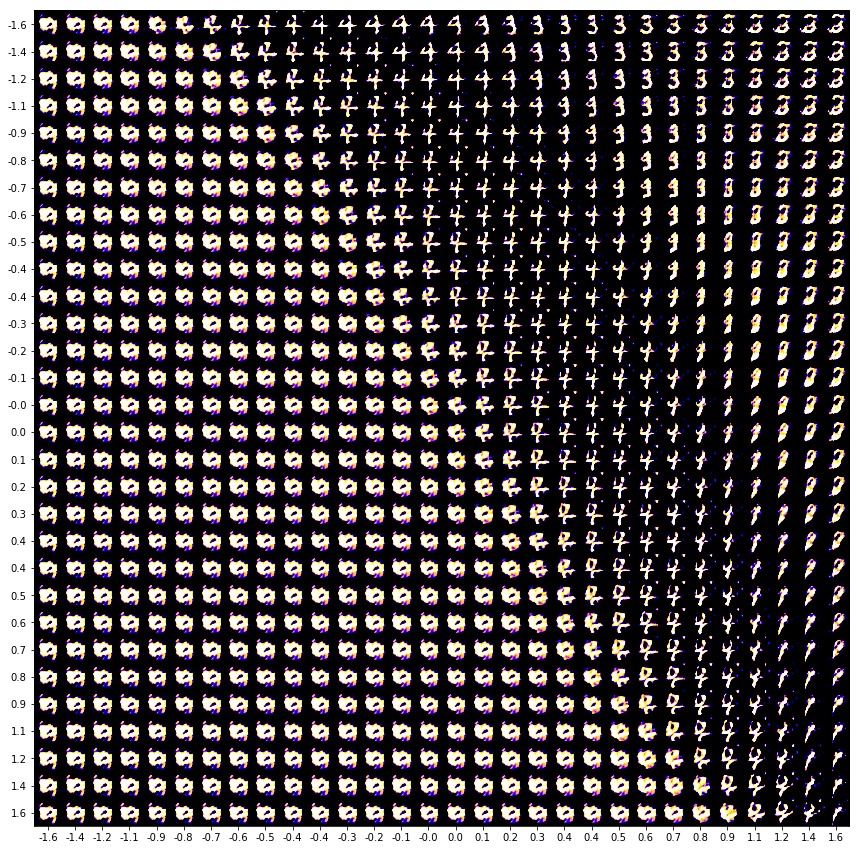

In [31]:
##PLOT
n = 30  # figure with 15x15 images 
image_size = img_cols
figure = np.zeros((image_size * n, image_size * n))
from scipy.stats import uniform
#metodo de la transformada inversa
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        noise = np.array([[xi, yi]])           
        x_decoded = G.predict(noise)
        figure[i * image_size: (i + 1) * image_size,
               j * image_size: (j + 1) * image_size] = x_decoded[0][:,:,0]
plt.figure(figsize=(15, 15))
plt.imshow(figure,cmap='gnuplot2')
pos = np.arange(image_size/2,image_size*n,image_size)
plt.yticks(pos,np.round(grid_y,1))
plt.xticks(pos,np.round(grid_x,1))
plt.show()
#en los extremos del intervalo de confianza
grid = norm.ppf(np.linspace(0.000005, 0.999995, n))

g) Con una distribución tipo normal no se notan diferencias sustanciales en los datos cuantitativos, pero sí en los cualitativos y como se puede ver en la imagen lo que crea el generador es completamente distinto, los números ahora están distribuidos por sectores y a simple vista estos parecieran ser peores que los de la versión uniforme.

C:\Users\Daniel\Anaconda3\lib\site-packages\keras\activations.py:115: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
C:\Users\Daniel\Anaconda3\lib\site-packages\keras\engine\training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0: [D loss: 0.693359, acc: 0.531250]  [G loss: 2.451114, acc: 0.000000]
500: [D loss: 0.617817, acc: 0.679688]  [G loss: 1.340777, acc: 0.000000]
1000: [D loss: 0.606489, acc: 0.671875]  [G loss: 0.877477, acc: 0.296875]
1500: [D loss: 0.490285, acc: 0.773438]  [G loss: 0.950652, acc: 0.281250]
2000: [D loss: 0.763809, acc: 0.625000]  [G loss: 1.147229, acc: 0.250000]
2500: [D loss: 0.224424, acc: 0.898438]  [G loss: 0.035699, acc: 0.984375]
3000: [D loss: 0.408145, acc: 0.898438]  [G loss: 1.728722, acc: 0.359375]
3500: [D loss: 0.034431, acc: 0.992188]  [G loss: 0.000189, acc: 1.000000]
4000: [D loss: 0.071600, acc: 0.976562]  [G loss: 0.003360, acc: 1.000000]
4500: [D loss: 0.130172, acc: 0.968750]  [G loss: 0.172220, acc: 0.890625]
4500: [D loss: 0.130172, acc: 0.968750]  [G loss: 0.172220, acc: 0.890625]


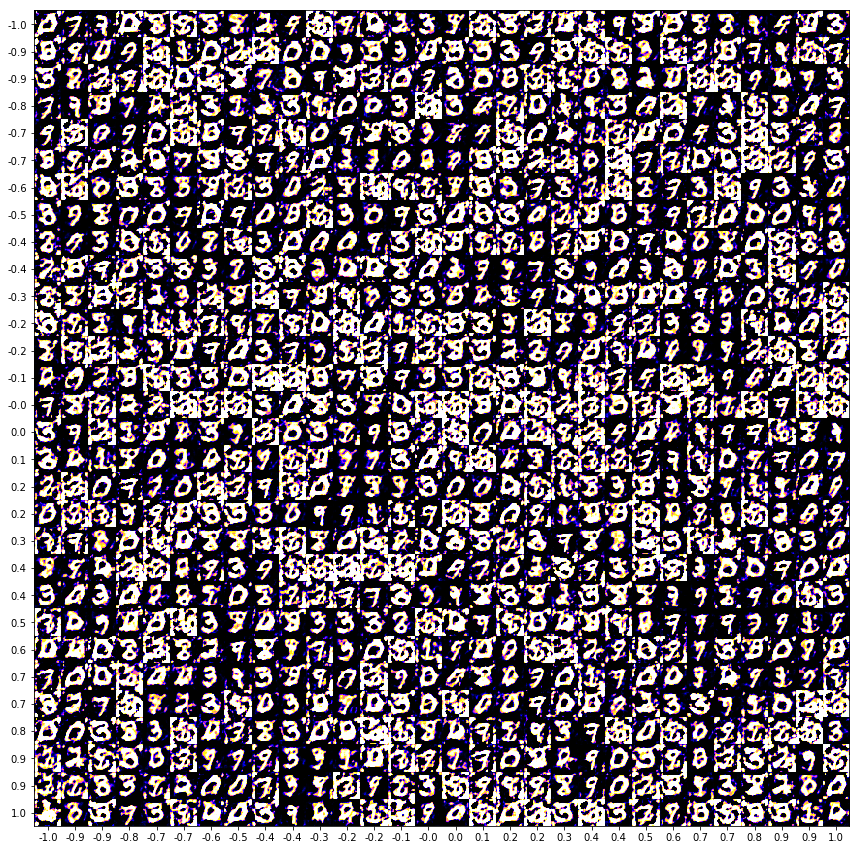

In [34]:
D = Sequential()
depth = 64
dropout = 0.4
input_shape = (img_rows, img_cols, channel)
D.add(Conv2D(depth*1, (5,5), strides=2, input_shape=input_shape,padding='same', activation=LeakyReLU(alpha=0.2)))
D.add(Dropout(dropout))
D.add(Conv2D(depth*2, (5,5), strides=2, padding='same',activation=LeakyReLU(alpha=0.2)))
D.add(Dropout(dropout))
D.add(Conv2D(depth*4, (5,5), strides=2, padding='same',activation=LeakyReLU(alpha=0.2)))
D.add(Dropout(dropout))
D.add(Flatten())
D.add(Dense(1024,activation=LeakyReLU(alpha=0.2)))
D.add(Dense(1,activation='sigmoid'))

G = Sequential()
dim = 14
input_dim= 5 #para que sea similar al vAE
G.add(Dense(128, input_dim=input_dim))
G.add(BatchNormalization())
G.add(Activation('relu'))
G.add(Dense(dim*dim*depth))
G.add(BatchNormalization())
G.add(Activation('relu'))
G.add(Reshape((dim, dim, depth)))
G.add(Conv2DTranspose(int(depth/2), (3,3), padding='same',strides=(2,2)))
G.add(BatchNormalization())
G.add(Activation('relu'))
G.add(Conv2DTranspose(int(depth/2), (3,3), padding='same'))
G.add(BatchNormalization())
G.add(Activation('relu'))
G.add(Conv2DTranspose(channel, (3,3), padding='same')) 
G.add(Activation('sigmoid')) 

optimizer = RMSprop(lr=0.0008, clipvalue=1.0, decay=6e-8)
DM = Sequential()
DM.add(D)
DM.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])
## Adversarial model (Generator->Discriminator)
D.trainable=False #set the discriminator freeze  (fixed params)
optimizer = RMSprop(lr=0.0004, clipvalue=1.0, decay=3e-8)
AM = Sequential()
AM.add(G)
AM.add(D)
AM.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])

def train_on_steps(X_train,DM,AM,G,steps,batch_size):
    history = {"d":[],"g":[]}
    for e in range(train_steps):
        # Make generative images
        image_batch = X_train[np.random.randint(0,X_train.shape[0],size=batch_size),:,:,:] #sample images from real data
        noise_gen = np.random.uniform(-1,1,size=[batch_size,input_dim]) #sample image from generated data
        generated_images = G.predict(noise_gen) #fake images
        # Train discriminator on generated images
        X = np.concatenate((image_batch, generated_images))
        #create labels
        y = np.ones([2*batch_size,1])
        y[batch_size:,:] = 0
        d_loss  = DM.train_on_batch(X,y)
        history["d"].append(d_loss)
        # train Generator-Discriminator stack on input noise to non-generated output class
        noise_tr = np.random.uniform(-1,1,size=[batch_size,input_dim])
        y = np.ones([batch_size, 1])
        g_loss = AM.train_on_batch(noise_tr, y)
        history["g"].append(g_loss)
        if(e%(500)==0):
            log_mesg = "%d: [D loss: %f, acc: %f]" % (e, d_loss[0], d_loss[1])
            log_mesg = "%s  [G loss: %f, acc: %f]" % (log_mesg, g_loss[0], g_loss[1])
            print(log_mesg)
    print(log_mesg)        
    return history
train_steps = 5000 #or few if  you want
hist = train_on_steps(X_train,DM,AM,G,train_steps,64)
    
##PLOT
n = 30  # figure with 15x15 images 
image_size = img_cols
figure = np.zeros((image_size * n, image_size * n))
from scipy.stats import uniform
#metodo de la transformada inversa
grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        noise = np.random.uniform(-1.0, 1.0, size=[N, input_dim])          
        x_decoded = G.predict(noise)
        figure[i * image_size: (i + 1) * image_size,
               j * image_size: (j + 1) * image_size] = x_decoded[0][:,:,0]
plt.figure(figsize=(15, 15))
plt.imshow(figure,cmap='gnuplot2')
pos = np.arange(image_size/2,image_size*n,image_size)
plt.yticks(pos,np.round(grid_y,1))
plt.xticks(pos,np.round(grid_x,1))
plt.show()
#en los extremos del intervalo de confianza
grid = norm.ppf(np.linspace(0.000005, 0.999995, n))    

h) Al aumentar la cantidad de variables no sé nota diferencia importante en lo que respecta a lo cuantitativo, sin embargo en la imagen se puede ver como los números generados son de una mejor calidad visual. Es interesante ver que el número de pixeles encendidos aumenta con respecto a la anterior versión.